# Importing Modules

In [1]:
from keras.layers import Dense, Flatten, Activation
from tensorflow.keras import Input
from keras.layers import Dropout, BatchNormalization
from keras.optimizers import SGD
from keras.models import Model

from keras.models import Sequential
from keras.callbacks import EarlyStopping

from tensorboard.plugins.hparams import api as hp

import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit

import pandas as pd
import numpy as np
import seaborn as sns
import json

import os

In [2]:
!pip install logzero

In [3]:
root_path = os.path.join('embedder', 'embedded_data')
root_path_logs = os.path.join('embedder', 'tensorboard_logs')

In [4]:
launch_option = input("If the notebook is launched from local git, press 1. If the notebook is launched from Google Colab, press 2: ")
launch_option = int(launch_option)

If the notebook is launched from local git, press 1. If the notebook is launched from Google Colab, press 2: 2


In [5]:
if launch_option == 1:
    os.chdir("../..")

elif launch_option == 2:

    print(os.path.join(os.getcwd(), "nlp_consulting_project"))
    if os.path.exists(os.path.join(os.sep, 'content', "nlp_consulting_project")):
        print("Directory nlp_consulting_project exists")
        os.chdir(os.path.join(os.sep, 'content', "nlp_consulting_project"))
        !git pull
    else:
        !git clone https://github.com/hehlinge42/nlp_consulting_project.git
        os.chdir("nlp_consulting_project")
        
    zip_dir = os.path.join("embedder", "embedded_data", "zip")
    embedded_data_dir = os.path.join("embedder", "embedded_data")
    embedding_list = ["lsi", "spark_lsi", "fasttext", "word2vec"]

    merger_filepath = os.path.join("scraper", "merger.py")
    balanced_filepath = os.path.join("scraper", "generate_balanced_dataset.py")
    
    !python3 $merger_filepath
    !python3 $balanced_filepath
    reviews = pd.read_json(os.path.join('scraper', 'scraped_data', 'merged_data', 'merged_reviews.json'), lines=True)
    reviews.set_index(['review_id'], inplace=True)
    reviews = reviews['rating']

    if not os.path.exists(zip_dir):
        os.makedirs(zip_dir)

    for embedding in embedding_list:
        dir = os.path.join("embedder", "embedded_data", embedding)

        if not os.path.exists(dir):
            os.makedirs(dir)

        file = os.path.join(zip_dir, embedding + ".zip")
        !unzip $file -d $dir
        
        if embedding == 'spark_lsi':
            X = pd.read_csv(os.path.join(embedded_data_dir, embedding, embedding + ".csv"))
            review_ids = pd.read_csv(os.path.join('cleaner', 'cleaned_data', 'restaurant_tfidf_sparse_review_ids.csv'), index_col=['review_id'])
            X['review_id'] = review_ids.index.values
            X.set_index(['review_id'], inplace=True)
        else:
            X = pd.read_csv(os.path.join(embedded_data_dir, embedding, embedding + ".csv"), index_col=['review_id'])

        Xy = X.merge(reviews, left_index=True, right_index=True)
        Xy['rating'] -= 1
        y = Xy['rating']
        sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
        for train_index, test_index in sss.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        y_train = tf.keras.utils.to_categorical(y_train, num_classes=None)   
        y_test = tf.keras.utils.to_categorical(y_test, num_classes=None)

        X_train.to_csv(os.path.join(root_path, embedding, 'X_train_' + embedding + '.csv'))
        X_test.to_csv(os.path.join(root_path, embedding, 'X_test_' + embedding + '.csv'))
        with open(os.path.join(root_path, embedding, 'y_train_' + embedding + '.npy'), 'wb+') as f:
            np.save(f, y_train)
        with open(os.path.join(root_path, embedding, 'y_test_' + embedding + '.npy'), 'wb+') as f:
            np.save(f, y_test)

from embedder.src.universal_hp_optimizer import UniversalHPOptimizer

/content/nlp_consulting_project
Cloning into 'nlp_consulting_project'...
remote: Enumerating objects: 4949, done.
remote: Counting objects: 100% (4949/4949), done.
remote: Compressing objects: 100% (2576/2576), done.
remote: Total 10885 (delta 1510), reused 4934 (delta 1509), pack-reused 5936
Receiving objects: 100% (10885/10885), 766.82 MiB | 40.04 MiB/s, done.
Resolving deltas: 100% (3491/3491), done.
Checking out files: 100% (6502/6502), done.
[I 210220 17:51:32 merger:8] In merger.py, pwd returns /content/nlp_consulting_project
[I 210220 17:51:32 merger:15] In merger.py, changing working directory to /content/nlp_consulting_project
[W 210220 17:51:32 merger:92] Creating directory /content/nlp_consulting_project/scraper/scraped_data/merged_data
[I 210220 17:51:32 merger:95] Merging restaurant files
[I 210220 17:51:32 merger:71] Merging existing_files ['/content/nlp_consulting_project/scraper/scraped_data/restaurants/restaurants_run_5.json', '/content/nlp_consulting_project/scraper/s

In [6]:
def generate_model(hparams, print_summary=False):

    model = tf.keras.models.Sequential()
    model.add(Input(shape=(hparams['nb_columns'],)))

    model.add(Dense(128, activation=tf.nn.relu))
    if hparams['batch_normalization'] is True:
        model.add(tf.keras.layers.BatchNormalization())
    model.add(Dropout(rate=hparams["dropout"]))

    model.add(Dense(64, activation=tf.nn.relu))
    model.add(Dense(5, activation=tf.nn.softmax))
    model.compile(loss='categorical_crossentropy', metrics='accuracy', optimizer='adam')

    if print_summary is True:
        model.summary()

    return model

In [7]:
%load_ext tensorboard

In [8]:
params = {
    "epochs": hp.HParam('epochs', hp.Discrete([20])),
    "batch_size": hp.HParam('batch_size', hp.Discrete([32, 64])),
    'batch_normalization': hp.HParam('batch_normalization', hp.Discrete([False], dtype=bool)),
    'dropout': hp.HParam('dropout', hp.Discrete([0.5, 0.6, 0.8], dtype=float)),
    'nb_columns': hp.HParam('nb_columns', hp.Discrete([350, 450], dtype=int))
}

# Spark LSI

In [9]:
embedding_path = os.path.join(root_path, 'spark_lsi')
lsi_logs = os.path.join(root_path_logs, 'spark_lsi')

print(embedding_path)

embedder/embedded_data/spark_lsi


## Loading data

In [10]:
X_train_spark_lsi = pd.read_csv(os.path.join(embedding_path, 'X_train_spark_lsi.csv'), index_col=['review_id'])
X_test_spark_lsi = pd.read_csv(os.path.join(embedding_path, 'X_test_spark_lsi.csv'), index_col=['review_id'])
y_train_spark_lsi = np.load(os.path.join(embedding_path, 'y_train_spark_lsi.npy'))
y_test_spark_lsi = np.load(os.path.join(embedding_path, 'y_test_spark_lsi.npy'))

## Hyper parameters optimization

In [11]:
!rm -rf $lsi_logs
hp_spark_lsi = UniversalHPOptimizer(params, generate_model, log_dir=lsi_logs, print_summary=True)
hp_spark_lsi.run_all(X_train_spark_lsi, y_train_spark_lsi, X_test_spark_lsi, y_test_spark_lsi)


--- Starting trial: run-1
{'dropout': 0.5, 'epochs': 20, 'batch_size': 32, 'optimizer': 'SGD', 'batch_normalization': False, 'early_stopping': 3, 'nb_columns': 350}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               44928     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 53,509
Trainable params: 53,509
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
398/398 [==============================] - 4s 4ms/step - loss: 1.4739 - a

In [12]:
spark_lsi_model = hp_spark_lsi.best_model
spark_lsi_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 128)               57728     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_23 (Dense)             (None, 5)                 325       
Total params: 66,309
Trainable params: 66,309
Non-trainable params: 0
_________________________________________________________________


In [13]:
y_pred_spark_lsi = spark_lsi_model.predict(
    X_test_spark_lsi.iloc[:, 0:hp_spark_lsi.best_params['nb_columns']], batch_size=None, verbose=1, steps=None, callbacks=None, max_queue_size=10,
    workers=1, use_multiprocessing=False)

125/125 [==============================] - 0s 1ms/step


In [14]:
# %tensorboard --logdir $lsi_logs

In [15]:
y_test_spark_lsi = y_test.argmax(1) + 1
y_pred_spark_lsi = y_pred_spark_lsi.argmax(1) + 1

# Word2Vec

In [16]:
embedding_path = os.path.join(root_path, 'word2vec')
word2vec_logs = os.path.join(root_path_logs, 'word2vec')

## Loading data

In [17]:
X_train_word2vec = pd.read_csv(os.path.join(embedding_path, 'X_train_word2vec.csv'), index_col=['review_id'])
X_test_word2vec = pd.read_csv(os.path.join(embedding_path, 'X_test_word2vec.csv'), index_col=['review_id'])
y_train_word2vec = np.load(os.path.join(embedding_path, 'y_train_word2vec.npy'))
y_test_word2vec = np.load(os.path.join(embedding_path, 'y_test_word2vec.npy'))

## Hyper parameters optimization

In [18]:
!rm -rf $word2vec_logs
hp_word2vec = UniversalHPOptimizer(params, generate_model, log_dir=word2vec_logs, print_summary=True)
hp_word2vec.run_all(X_train_word2vec, y_train_word2vec, X_test_word2vec, y_test_word2vec)


--- Starting trial: run-1
{'dropout': 0.5, 'epochs': 20, 'batch_size': 32, 'optimizer': 'SGD', 'batch_normalization': False, 'early_stopping': 3, 'nb_columns': 350}
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 128)               44928     
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_38 (Dense)             (None, 5)                 325       
Total params: 53,509
Trainable params: 53,509
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
245/245 [==============================] - 1s 4ms/step - loss: 1.4705 

In [19]:
word2vec_model = hp_word2vec.best_model
word2vec_model.summary() # Calculate number of input columns

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 128)               57728     
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_41 (Dense)             (None, 5)                 325       
Total params: 66,309
Trainable params: 66,309
Non-trainable params: 0
_________________________________________________________________


In [20]:
y_pred_word2vec = word2vec_model.predict(
    X_test_word2vec.iloc[:, 0:hp_word2vec.best_params['nb_columns']], batch_size=None, verbose=1, steps=None, callbacks=None, max_queue_size=10,
    workers=1, use_multiprocessing=False)

77/77 [==============================] - 0s 1ms/step


In [21]:
# %tensorboard --logdir $word2vec_logs

In [22]:
y_test_word2vec = y_test_word2vec.argmax(1) + 1
y_pred_word2vec = y_pred_word2vec.argmax(1) + 1

# Fast Text

In [23]:
embedding_path = os.path.join(root_path, 'fasttext')
fasttext_logs = os.path.join(root_path_logs, 'fasttext')

## Loading data

In [24]:
X_train_fasttext = pd.read_csv(os.path.join(embedding_path, 'X_train_fasttext.csv'), index_col=['review_id'])
X_test_fasttext = pd.read_csv(os.path.join(embedding_path, 'X_test_fasttext.csv'), index_col=['review_id'])
y_train_fasttext = np.load(os.path.join(embedding_path, 'y_train_fasttext.npy'))
y_test_fasttext = np.load(os.path.join(embedding_path, 'y_test_fasttext.npy'))

## Hyper parameters optimization

In [25]:
!rm -rf $fasttext_logs
hp_fasttext = UniversalHPOptimizer(params, generate_model, log_dir=fasttext_logs, print_summary=True)
hp_fasttext.run_all(X_train_fasttext, y_train_fasttext, X_test_fasttext, y_test_fasttext)


--- Starting trial: run-1
{'dropout': 0.5, 'epochs': 20, 'batch_size': 32, 'optimizer': 'SGD', 'batch_normalization': False, 'early_stopping': 3, 'nb_columns': 350}
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 128)               44928     
_________________________________________________________________
dropout_24 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_73 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_74 (Dense)             (None, 5)                 325       
Total params: 53,509
Trainable params: 53,509
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
245/245 [==============================] - 1s 4ms/step - loss: 1.5624 

In [26]:
fasttext_model = hp_fasttext.best_model
fasttext_model.summary() # Calculate number of input columns

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_84 (Dense)             (None, 128)               44928     
_________________________________________________________________
dropout_28 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_85 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_86 (Dense)             (None, 5)                 325       
Total params: 53,509
Trainable params: 53,509
Non-trainable params: 0
_________________________________________________________________


In [27]:
y_pred_fasttext = fasttext_model.predict(
    X_test_fasttext.iloc[:, 0:hp_fasttext.best_params['nb_columns']], batch_size=None, verbose=1, steps=None, callbacks=None, max_queue_size=10,
    workers=1, use_multiprocessing=False)

77/77 [==============================] - 0s 1ms/step


In [28]:
# %tensorboard --logdir $fasttext_logs

In [29]:
y_test_fasttext = y_test_fasttext.argmax(1) + 1
y_pred_fasttext = y_pred_fasttext.argmax(1) + 1

# Performance analysis

## Accuracy

In [30]:
print(f"Best accuracy reached using LSI: {hp_spark_lsi.best_accuracy}")
print(f"Best accuracy reached using Word2Vec: {hp_word2vec.best_accuracy}")
print(f"Best accuracy reached using FastText: {hp_fasttext.best_accuracy}")

Best accuracy reached using LSI: 0.5881317853927612
Best accuracy reached using Word2Vec: 0.5888843536376953
Best accuracy reached using FastText: 0.46015527844429016


LSI and Word2Vec achieve similar performances at 60%, 3 times better than chance. FastText has lower performances with only 45% of accurate predictions

## Confusion matrices

In [32]:
conf_matrix_lsi = confusion_matrix(y_test_spark_lsi, y_pred_spark_lsi)
sns.heatmap(conf_matrix_lsi/np.sum(conf_matrix_lsi, axis=1), annot=True, fmt='.2%', cmap='Blues')

ValueError: ignored

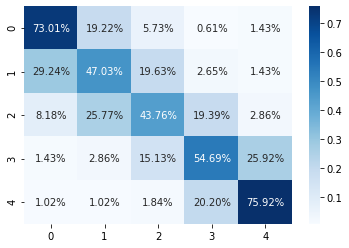

In [33]:
conf_matrix_word2vec = confusion_matrix(y_test_word2vec, y_pred_word2vec)
sns.heatmap(conf_matrix_word2vec/np.sum(conf_matrix_word2vec, axis=1), annot=True, fmt='.2%', cmap='Blues')

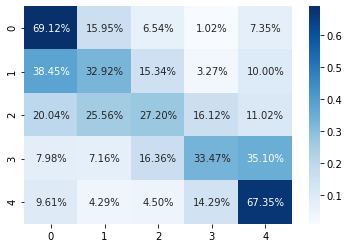

In [34]:
conf_matrix_fasttext = confusion_matrix(y_test_fasttext, y_pred_fasttext)
sns.heatmap(conf_matrix_fasttext/np.sum(conf_matrix_fasttext, axis=1), annot=True, fmt='.2%', cmap='Blues')

All three models, especially the ones using LSI and Word2Vec embedding make small mistakes, usually confunding a rating with the next or previous one. Cases where the gap between the truth and the prediction is bigger than 1 star are rare. This is a good indication that the model makes sense even if its accuracy is not optimal

## Optimal dimensionality

All three models achieve relative good performances starting from 150 dimensions. This indicates that the first dimensions capture a lot of the variance of all reviews. Adding extra dimensions can improve marginally the performance but also increases the risk of overfitting. The hyperparameter optimization indicate different optimal number of parameters for the 3 models, that could lead to difference in the training time of each model. Nevertheless, the resulting differences in the accuracy are too small to consider this criteria

# Conclusion

Using the same neural network, Word2Vec and LSI embeddings enable to achieve similar performances in guessing the rating of reviews. Nevertheless, the easy Spark implementation of the LSI embedding makes it a more scalable technique if the number of reviews and/or the number of dimensions increases.

# Downloads

## Logs

In [ ]:
from google.colab import files

download_zip_dir = os.path.join('embedder', 'tensorboard_logs')
download_zip_file = os.path.join('embedder', 'tensorboard_logs.zip')
!zip -r $download_zip_file $download_zip_dir
files.download(download_zip_file)

## Trained models

In [ ]:
trained_models_path = os.path.join('embedder', 'trained_models')
if not os.path.exists(trained_models_path):
    os.makedirs(trained_models_path)

spark_lsi_model.save(os.path.join(trained_models_path, 'spark_lsi.h5'))
word2vec_model.save(os.path.join(trained_models_path, 'word2vec.h5'))
fasttext_model.save(os.path.join(trained_models_path, 'fasttext.h5'))

In [ ]:
from google.colab import files

In [ ]:
word2vec_params_path = os.path.join('embedder', 'trained_models', 'word2vec_params.json')
with open(os.path.join('embedder', 'trained_models', 'word2vec_params.json'), 'w+') as file:
    json.dump(hp_word2vec.best_params, file)
    
files.download(word2vec_params_path)

In [ ]:
spark_params_path = os.path.join('embedder', 'trained_models', 'spark_params.json')
with open(spark_params_path, 'w+') as file:
    json.dump(hp_spark_lsi.best_params, file)
    
files.download(spark_params_path)

In [ ]:
fasttext_params_path = os.path.join('embedder', 'trained_models', 'fasttext_params.json')
with open(fasttext_params_path, 'w+') as file:
    json.dump(hp_fasttext.best_params, file)
    
files.download(fasttext_params_path)

In [ ]:
download_zip_file = os.path.join('embedder', 'trained_models.zip')
!zip -r $download_zip_file $trained_models_path
files.download(download_zip_file)